In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import json
from multiprocessing import Pool
from lampe.data import JointLoader
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import coverage_plot
from tqdm import tqdm
from itertools import islice

from cryo_sbi.inference.models import build_models
from cryo_sbi import CryoEmSimulator
from cryo_sbi.inference import priors

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
file_name = '23_03_17_missmatch'
data_dir = "../experiments/benchmark_hsp90/results/raw_data/"
fig_dir = "../experiments/benchmark_hsp90/results/plots/"
config_dir = "../experiments/benchmark_hsp90/"                   
device = 'cuda'                  
save_figures = True

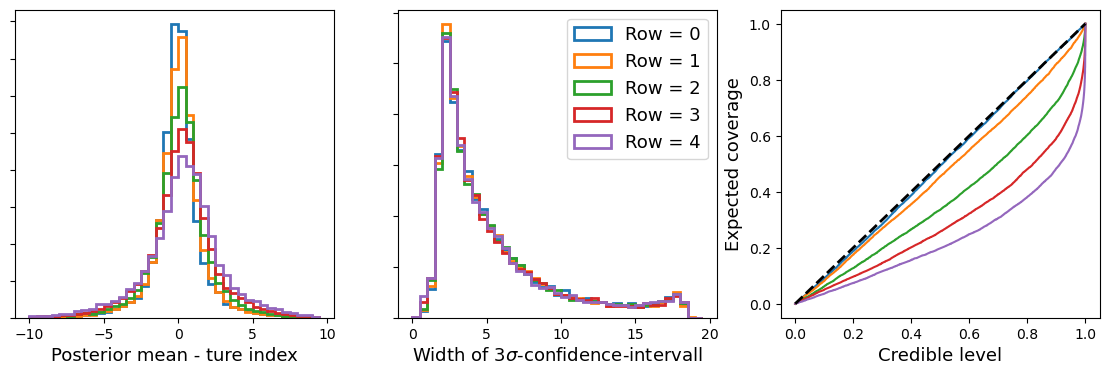

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
labels = [f'Row = {row}' for row in range(5)]
file_names_means = [f'{data_dir}{file_name}_mean_distance_r={row}.npy' for row in range(5)]
file_names_confidence = [f'{data_dir}{file_name}_confidence_widths_r={row}.npy' for row in range(5)]


for file, name in zip(file_names_means, labels):
    mean_distances = np.load(file)
    axes[0].hist(mean_distances, bins=np.arange(-10, 10, 0.5), histtype='step', density=True, label=name, linewidth=2)
axes[0].set_xlabel(r'Posterior mean - ture index', fontsize=13)
axes[0].set_yticklabels([])


for file, name in zip(file_names_confidence, labels):
    confidence_widths = np.load(file)
    axes[1].hist(confidence_widths, bins=np.arange(0, 20, 0.5), histtype='step', density=True, label=name, linewidth=2)
axes[1].set_xlabel(r'Width of 3$\sigma$-confidence-intervall', fontsize=13)
axes[1].set_yticklabels([])
axes[1].legend(fontsize=13)


levels, coverages = torch.load("../experiments/benchmark_hsp90/results/raw_data/sbc_rows.pt")
axes[2].plot(levels, coverages)
axes[2].plot([0, 1], [0, 1], linestyle="--", linewidth=2, color="black")
axes[2].set_xlabel('Credible level', fontsize=13)
axes[2].set_ylabel('Expected coverage', fontsize=13)

if save_figures:
    plt.savefig(f'{fig_dir}{file_name}_missspecified_model.pdf', dpi=500, bbox_inches='tight')

In [ ]:
snrs = np.logspace(-0.5, -1.5, 9)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
labels = [f'$\Delta$SNR = {snr-0.1:.3f}' for snr in snrs]
file_names_means = [f'{data_dir}{file_name}_mean_distance_snr={snr}.npy' for snr in snrs]
file_names_confidence = [f'{data_dir}{file_name}_confidence_widths_snr={snr}.npy' for snr in snrs]


for file, name in zip(file_names_means, labels):
    mean_distances = np.load(file)
    axes[0].hist(mean_distances, bins=np.arange(-15, 20, 0.3), histtype='step', density=True, label=name, linewidth=2)
axes[0].set_xlabel(r'Posterior mean - ture index')


for file, name in zip(file_names_confidence, labels):
    confidence_widths = np.load(file)
    axes[1].hist(confidence_widths, bins=np.arange(0, 15, 0.3), histtype='step', density=True, label=name, linewidth=2)
axes[1].set_xlabel(r'with of $95\%-$confidence intervall')
axes[1].legend()


levels, coverages = torch.load(f'{data_dir}{file_name}_sbc_snr')
axes[2].plot(levels, coverages)
axes[2].plot([0, 1], [0, 1], linestyle="--", linewidth=2, color="black")
axes[2].set_xlabel('Credible level', fontsize=13)
axes[2].set_ylabel('Expected coverage', fontsize=13)


if save_figures:
    plt.savefig(f'{fig_dir}{file_name}_missspecified_snr.pdf', dpi=500)

In [ ]:
file_name = 'snr01_wideres50_128'    # File name 
data_dir = "/"
config_dir = "../experiments/benchmark_hsp90/"
num_samples_stats = 20000           # Number of simulations for computing posterior stats
num_samples_SBC = 10000             # Number of simulations for SBC
num_posterior_samples_SBC = 4096    # Number of posterior samples for each SBC simulation
num_samples_posterior = 50000       # Number of samples to draw from posterior
num_samples_umap = 10000            # Number of simualtions for UMAP analysis
batch_size_sampling = 100           # Batch size for sampling posterior
batch_size_latent = 1000            # Batch size for calculating latent representation
num_workers = 24                    # Number of CPU cores
device = 'cuda'                     # Device for computations

## Load cryo-em simulator and posterior with correct config

In [ ]:
cryosbi = CryoEmSimulator(config_dir + "image_params_snr01_128.json")

In [ ]:
train_config = json.load(open(config_dir + "resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load(config_dir + "resnet18_encoder_snr01.estimator"))
estimator.cuda()
estimator.eval();

In [ ]:
models = np.load(json.load(open(config_dir + "image_params_snr01_128.json"))["MODEL_FILE"])

## Compute posterior accuracy and precision for structre missmatch

In [ ]:
for row in range(5):
    cryosbi.models = models[:, row]

    indices = priors.get_unirom_prior_1d(cryosbi.get_max_index()).sample((num_samples_stats,))
    images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

    theta_samples = []
    with torch.no_grad():
        for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
            samples = estimator.sample(
                batched_images.cuda(non_blocking=True),
                shape=(num_samples_posterior,)
            ).cpu()
            theta_samples.append(samples.reshape(-1, batch_size_sampling))
    samples = torch.cat(theta_samples, dim=1)

    mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
    posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
    confidence_widths = posterior_quantiles[1] - posterior_quantiles[0]

    np.save(f'confidence_widths_r={row}_{file_name}.npy', np.array(confidence_widths))
    np.save(f'mean_distance_r={row}_{file_name}.npy', mean_distance)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
labels = [f'Row = {row}' for row in range(5)]
file_names_means = [f'mean_distance_r={row}_{file_name}.npy' for row in range(5)]
file_names_confidence = [f'confidence_widths_r={row}_{file_name}.npy' for row in range(5)]


for file, name in zip(file_names_means, labels):
    mean_distances = np.load(file)
    axes[0].hist(mean_distances, bins=np.arange(-10, 10, 0.5), histtype='step', density=True, label=name, linewidth=2)
axes[0].set_xlabel(r'Posterior mean - ture index', fontsize=13)
axes[0].legend()


for file, name in zip(file_names_confidence, labels):
    confidence_widths = np.load(file)
    axes[1].hist(confidence_widths, bins=np.arange(0, 15, 0.5), histtype='step', density=True, label=name, linewidth=2)
axes[1].set_xlabel(r'Width of 3$\sigma$-confidence-intervall', fontsize=13)
axes[1].legend()


plt.savefig(f'missspecified_model_{file_name}.pdf', dpi=500)

In [ ]:
cryosbi.models = models[:, 4]
indices = priors.get_unirom_prior_1d(cryosbi.get_max_index()).sample((20000,))
images_wrong_row = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [ ]:
samples = sample_posterior(estimator, images_wrong_row, num_samples=50000, batch_size=100, device='cuda')

In [ ]:
posterior_quantiles = np.quantile(samples.numpy(), [0.005, 0.995], axis=0)
confidence_widths = posterior_quantiles[1] - posterior_quantiles[0]

In [ ]:
off_index = []
for idx, index in enumerate(indices):
    lower, upper = posterior_quantiles[:, idx] 
    if index < lower or index > upper:
        off_index.append(idx)
print(len(off_index)/len(indices))

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.hist(samples[:, idx].cpu().flatten().numpy(), bins=np.arange(0, 20, 0.2),histtype='step', density=True, linewidth=1.5)
    ax.axvline(indices.reshape(-1)[idx].item(), color='red')
    ax.set_yticks([])

In [ ]:
samples = estimator.sample(images_wrong_row[:100].cuda(), shape=(50000,))

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
for idx, ax in enumerate(axes[1]):
    ax.hist(samples[:, idx+40].cpu().flatten().numpy(), bins=np.arange(0, 20, 0.2),histtype='step', density=True, label=name, linewidth=1.5)
    ax.set_yticks([])
    ax.axvline(indices.reshape(-1)[idx].item(), color='red')

for idx, ax in enumerate(axes[0]):
    ax.imshow(images_wrong_row[idx].reshape(128, 128))
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig(f'example_missspecified_model_{file_name}.pdf')


## Compute posterior calibration under model missspecification

In [ ]:
all_levels = []
all_coverages = []

for i in range(5):
    cryosbi.models = models[:, i]
    loader = JointLoader(
        priors.get_unirom_prior_1d(cryosbi.max_index),
        cryosbi.simulator,
        vectorized=False,
        batch_size=1, 
        num_workers=num_workers,
        prefetch_factor=1
    )
    
    estimator.cuda()
    estimator.eval()
    
    levels, coverages = expected_coverage_mc(
        estimator.flow,
        ((estimator.standardize(theta.cuda()), x.cuda()) for theta, x in islice(loader, num_samples_SBC)),
        n = num_posterior_samples_SBC
    )
    
    all_levels.append(levels)
    all_coverages.append(coverages)
    
all_levels = torch.stack(all_levels, dim=1)
all_coverages = torch.stack(all_coverages, dim=1)

torch.save([all_levels, all_coverages], '../experiments/benchmark_hsp90/results/raw_data/sbc_rows.pt')

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
labels = [f'Row = {row}' for row in range(5)]
file_names_means = [f'mean_distance_r={row}_{file_name}.npy' for row in range(5)]
file_names_confidence = [f'confidence_widths_r={row}_{file_name}.npy' for row in range(5)]


for file, name in zip(file_names_means, labels):
    mean_distances = np.load(file)
    axes[0].hist(mean_distances, bins=np.arange(-10, 10, 0.5), histtype='step', density=True, label=name, linewidth=2)
axes[0].set_xlabel(r'Posterior mean - ture index', fontsize=13)
axes[0].set_yticklabels([])
axes[0].legend()


for file, name in zip(file_names_confidence, labels):
    confidence_widths = np.load(file)
    axes[1].hist(confidence_widths, bins=np.arange(0, 15, 0.5), histtype='step', density=True, label=name, linewidth=2)
axes[1].set_xlabel(r'Width of 3$\sigma$-confidence-intervall', fontsize=13)
axes[1].set_yticklabels([])

levels, coverages = torch.load("../experiments/benchmark_hsp90/results/raw_data/sbc_rows.pt")
axes[2].plot(levels, coverages)
axes[2].plot([0, 1], [0, 1], linestyle="--", linewidth=2, color="black")
axes[2].set_xlabel('Credible level', fontsize=13)
axes[2].set_ylabel('Expected coverage', fontsize=13)


#plt.savefig(f'missspecified_model_{file_name}.pdf', dpi=500)

## Compute posterior accuracy and precision for SNR

In [ ]:
# Reset simulator
cryosbi = CryoEmSimulator(data_dir + "image_params_snr01_128.json")

In [ ]:
snrs = np.logspace(-0.5, -1.5, 9)
for snr in snrs:
    cryosbi.config['SNR'] = snr

    indices = priors.get_unirom_prior_1d(cryosbi.get_max_index()).sample((num_samples_stats,))
    images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

    theta_samples = []
    with torch.no_grad():
        for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
            samples = estimator.sample(
                batched_images.cuda(non_blocking=True), 
                shape=(num_samples_posterior,)
            ).cpu()
            theta_samples.append(samples.reshape(-1, batch_size_sampling))
    samples = torch.cat(theta_samples, dim=1)

    mean_distance = (samples.mean(dim=0) - indices.reshape(-1)).numpy()
    posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
    confidence_widths = posterior_quantiles[1] - posterior_quantiles[0]

    np.save(f'confidence_widths_snr={snr}_{file_name}.npy', np.array(confidence_widths))
    np.save(f'mean_distance_snr={snr}_{file_name}.npy', mean_distance)

In [ ]:
snrs = np.logspace(-0.5, -1.5, 9)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
labels = [f'SNR = {snr-0.1:.3f}' for snr in snrs]
file_names_means = [f'mean_distance_snr={snr}_{file_name}.npy' for snr in snrs]
file_names_confidence = [f'confidence_widths_snr={snr}_{file_name}.npy' for snr in snrs]


for file, name in zip(file_names_means, labels):
    mean_distances = np.load(file)
    axes[0].hist(mean_distances, bins=np.arange(-15, 20, 0.3), histtype='step', density=True, label=name, linewidth=2)
axes[0].set_xlabel(r'Posterior mean - ture index')


for file, name in zip(file_names_confidence, labels):
    confidence_widths = np.load(file)
    axes[1].hist(confidence_widths, bins=np.arange(0, 15, 0.3), histtype='step', density=True, label=name, linewidth=2)
axes[1].set_xlabel(r'with of $95\%-$confidence intervall')
axes[1].legend()


plt.savefig(f'missspecified_snr_{file_name}.pdf', dpi=500)

In [ ]:
cryosbi.config['SNR'] = 0.03
indices = priors.get_unirom_prior_1d(cryosbi.get_max_index()).sample((num_samples_umap,))
images_wrong_snr = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [ ]:
samples = estimator.sample(images_wrong_snr[:100].cuda(), shape=(50000,))

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
for idx, ax in enumerate(axes[1]):
    ax.hist(samples[:, idx+40].cpu().flatten().numpy(), bins=np.arange(0, 20, 0.2),histtype='step', density=True, label=name, linewidth=1.5)
    ax.set_yticks([])
    ax.axvline(indices.reshape(-1)[idx].item(), color='red')

for idx, ax in enumerate(axes[0]):
    ax.imshow(images_wrong_snr[idx].reshape(128, 128))
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig(f'example_missspecified_snr_{file_name}.pdf')

## Noise model missspecification misspecified SNR

In [ ]:
N_samples = 10000
all_levels = []
all_coverage = []

for snr in snrs:
    cryosbi.config['SNR'] = snr
    loader = JointLoader(
        priors.get_unirom_prior_1d(cryosbi.get_max_index()),
        cryosbi.simulator,
        vectorized=True,
        batch_size=1,
        num_workers=24,
        prefetch_factor=1
    )

    levels, coverages = expected_coverage_mc(
        estimator.flow,
        ((estimator.standardize(theta.cuda()), x.cuda()) for theta, x in islice(loader, num_samples_SBC)),
        n = num_posterior_samples_SBC
    )
    
    all_levels.append(levels)
    all_coverage.append(coverages)
    
all_levels = torch.stack(all_levels, dim=1)
all_coverage = torch.stack(all_coverage, dim=1)

In [ ]:
fig = coverage_plot(
    all_levels, all_coverage,
    legend=list(map(lambda x: f'SNR = {x:.3f}', np.logspace(-0.5, -1.5, 9))),
    figsize=(4.5, 4.5)
    )
fig.savefig(f'SBC_missspecifed_snr_{file_name}.pdf', dpi=500)

## Model missspecification non-Gaussian noise

In [ ]:
import simulator_colored_noise

In [ ]:
cryosbi_colored_noise = simulator_colored_noise.CryoEmSimulatorColoredNoise(data_dir + "image_params_snr01_128.json")

In [ ]:
loader = JointLoader(
    priors.get_unirom_prior_1d(cryosbi.get_max_index()),
    cryosbi_colored_noise.simulator,
    vectorized=True,
    batch_size=1,
    num_workers=num_workers,
    prefetch_factor=1
)

levels, coverages = expected_coverage_mc(
    estimator.flow,
    ((estimator.standardize(theta.cuda()), x.cuda()) for theta, x in islice(loader, num_samples_SBC)),
    n = num_posterior_samples_SBC
)

In [ ]:
fig = coverage_plot(levels, coverages)
fig.savefig(f'SBC_non_gaussian_snr_{file_name}.pdf', dpi=500)

In [ ]:
test_image = cryosbi_colored_noise.simulator(torch.tensor([10.]))
samples = estimator.sample(test_image.cuda(), shape=(100000,)).cpu()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].hist(samples.flatten().numpy(), bins=np.arange(0, 20, 0.2), histtype='step', linewidth=2, density=True)
axes[1].set_xlabel('Index')
axes[1].axvline(10, 0, 1, color='red')
axes[0].imshow(test_image.reshape(128, 128))
plt.savefig('Example_non_gaussian_noise.pdf', dpi=500)

## Model missspecification: No particle

In [ ]:
images_no_particle = torch.randn((num_samples_umap, 1, 128, 128))

In [ ]:
plt.imshow(images_no_particle[0].reshape(128, 128))

In [ ]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images_no_particle, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True),
            shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(samples.reshape(-1, batch_size_sampling))
samples = torch.cat(theta_samples, dim=1)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[1].hist(samples[:, :10].numpy(), bins=np.arange(0, 10, 0.1), histtype='step', density=True, linewidth=2)
axes[1].set_xlabel('Index')
axes[0].imshow(images_no_particle[0].reshape(128, 128))
plt.savefig(f'Posterior_no_particles_{file_name}.pdf', dpi=500)

## Model missspecification: Wrong particles (One arm of Hsp90)

In [ ]:
cryosbi = CryoEmSimulator(data_dir + "image_params_snr01_128.json")
cryosbi.models = models[:, 0, :, :603]

In [ ]:
test_image = cryosbi.simulator(torch.tensor([10.]))
samples = estimator.sample(test_image.cuda(), shape=(100000,)).cpu()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(test_image.reshape(128, 128))
_ = axes[1].hist(samples.flatten().numpy(), bins=np.arange(0, 20, 0.1), histtype='step', density=True, linewidth=2)
fig.savefig('Example_wrong_particle.pdf', dpi=500)

In [ ]:
indices = priors.get_unirom_prior_1d(cryosbi.get_max_index()).sample((num_samples_umap,))
images_wrong_particle = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [ ]:
theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images_wrong_particle, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(
            batched_images.cuda(non_blocking=True),
            shape=(num_samples_posterior,)
        ).cpu()
        theta_samples.append(samples.reshape(-1, batch_size_sampling))
samples = torch.cat(theta_samples, dim=1)

In [ ]:
_ = plt.hist(samples[:, :20].numpy(), bins=np.arange(0, 20, 0.1), histtype='step', density=True, label=name, linewidth=2)
plt.xlabel('Index')

## Detecting model missspecification

In [ ]:
images_mstar = [
    images_no_particle,
    images_wrong_particle,
    images_wrong_row,
    images_wrong_snr
]

In [ ]:
latent_repr_mstar = []
with torch.no_grad():
    for images in images_mstar:
        latent_space_samples = []
        for batched_images in torch.split(images, split_size_or_sections=batch_size_latent, dim=0):
            samples = estimator.embedding(
                batched_images.cuda(non_blocking=True)
            ).cpu()
            latent_space_samples.append(samples.reshape(batch_size_latent, -1))
        latent_repr_mstar.append(torch.cat(latent_space_samples, dim=0))  

In [ ]:
cryosbi = CryoEmSimulator(data_dir + "image_params_snr01_128.json")
indices = priors.get_unirom_prior_1d(cryosbi.get_max_index()).sample((num_samples_umap,))
images = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)

In [ ]:
latent_space_samples = []
batch_size = 1000
with torch.no_grad():
    for batched_images in torch.split(images, split_size_or_sections=batch_size_latent, dim=0):
        samples = estimator.embedding(batched_images.cuda(non_blocking=True)).cpu()
        latent_space_samples.append(samples.reshape(batch_size_latent, -1))
latent_repr_m = torch.cat(latent_space_samples, dim=0)

In [ ]:

theta_samples = []
with torch.no_grad():
    for batched_images in torch.split(images, split_size_or_sections=batch_size_sampling, dim=0):
        samples = estimator.sample(batched_images.cuda(non_blocking=True), shape=(num_samples_posterior,)).cpu()
        theta_samples.append(samples.reshape(-1, batch_size_sampling))
samples = torch.cat(theta_samples, dim=1)

In [ ]:
posterior_quantiles = np.quantile(samples.numpy(), [0.025, 0.975], axis=0)
confidence_widths = posterior_quantiles[1] - posterior_quantiles[0]

In [ ]:
cat_latent_samples = torch.cat((latent_repr_m, *latent_repr_mstar))

labels = torch.cat(
    (
    torch.zeros(10000),
    1 * torch.ones(10000),
    2 * torch.ones(10000),
    3 * torch.ones(10000),
    4 * torch.ones(10000)
    )
)

In [ ]:
import umap
reducer = umap.UMAP(metric='euclidean', n_components=2,  n_neighbors=50)
embedding = reducer.fit_transform(cat_latent_samples.numpy())

In [ ]:
name = ['Ground truth', 'No particle', 'Wrong particle', 'Wrong row (4)', 'Wrong SNR (0.03)']
colors = ['red', 'blue', 'green', 'yellow', 'black']
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for idx, i in enumerate(range(0, (len(images_mstar) + 1) * num_samples_umap, num_samples_umap)):
    axes[0].scatter(
        embedding[i:i+num_samples_umap, 0],
        embedding[i:i+num_samples_umap, 1],
        label=name[idx], c=colors[idx],
        s=0.1
    )
axes[0].legend(fontsize=10, markerscale=10)
axes[0].set_ylabel('UMAP dimsenion 1')

im1 = axes[1].scatter(
    embedding[0:num_samples_umap, 0],
    embedding[0:num_samples_umap, 1],
    c=indices.numpy(),
    s=0.5,
    cmap='viridis'
)
fig.colorbar(im1, ax=axes[1], label='Index')
axes[1].set_xlabel('UMAP dimsenion 2')

im2 = axes[2].scatter(
    embedding[0:num_samples_umap, 0],
    embedding[0:num_samples_umap, 1],
    c=confidence_widths,
    s=0.5, 
    cmap='viridis'
)
fig.colorbar(im2, ax=axes[2], label='Width of 95% confidence intervall')
plt.savefig(f'UMAP_analysis_{file_name}.png', dpi=500)

In [ ]:
def sample_posterior(estimator, images, num_samples, batch_size=100, device='cpu'):
    theta_samples = []

    if images.shape[0] > batch_size:
        images = torch.split(
            images,
            split_size_or_sections=batch_size,
            dim=0
        )

    with torch.no_grad():
        for image_batch in images:
            samples = estimator.sample(
                image_batch.to(device, non_blocking=True),
                shape=(num_samples,)
            ).cpu()
            theta_samples.append(samples.reshape(-1, batch_size))

    return  torch.cat(theta_samples, dim=1)


def compute_latent_repr(estimator, images, batch_size=1000, device='cpu'):
    latent_space_samples = []

    if images.shape[0] > batch_size:
        images = torch.split(images, split_size_or_sections=batch_size, dim=0)
    else:
        batch_size = 1

    with torch.no_grad():
        for image_batch in images:
            samples = estimator.embedding(
                image_batch.to(device, non_blocking=True)
            ).cpu()
            latent_space_samples.append(samples.reshape(batch_size, -1))

    return torch.cat(latent_space_samples, dim=0)